In [1]:
import numpy as np
np.random.seed(0)

## Create Random Ergodic Transition Matrix with the Desired Rank

In [2]:
p = 1000 #number of states
states = [i for i in range(p)]
r = 10 #rank of desired transition matrix

In [3]:
U = np.random.standard_normal(size=(p, r))
V = np.random.standard_normal(size=(p, r))

def normalizeMatrix(H, axis=1):
    axis_sum =  np.sum(H, axis=axis)
    if axis:
        return np.divide(H, axis_sum.reshape(-1, 1))
    else:
        return np.divide(H, axis_sum.reshape(1, -1))


U1 = normalizeMatrix(U * U)
V1 = normalizeMatrix(V * V, axis = 0)

M = U1 @ V1.transpose()

print(np.linalg.matrix_rank(M))

10


### Visualize Transition Matrix

<AxesSubplot:>

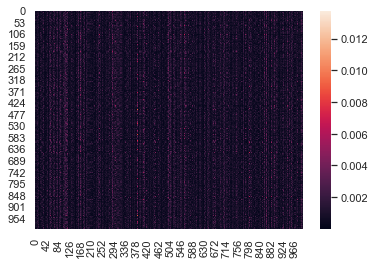

In [4]:
import seaborn as sns; sns.set_theme()
def visualizeMatrix(H):
    ax = sns.heatmap(H)
    return ax

visualizeMatrix(M)

### Simulate Random Walk od Size $ \textbf{n} = p^2$

In [5]:
from tqdm.notebook import tqdm

# n = round(100 * p * np.log(p))
n = p**2
current_state = np.random.choice(states)
path = [current_state]
for i in tqdm(range(n)):
    current_state = np.random.choice(states, p = M[current_state])
    path.append(current_state)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Counting State transition based on random walk data

In [6]:

N = np.zeros((p, p))
for k in tqdm(range(n)):
    i, j = path[k], path[k + 1]
    N[i, j] += 1
print(N)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[[ 1.  1.  2. ...  3.  2.  4.]
 [ 2.  1.  1. ...  0.  1.  0.]
 [ 0.  1. 12. ...  3.  4.  2.]
 ...
 [ 0.  0.  1. ...  1.  4.  1.]
 [ 3.  2.  3. ...  2.  2.  2.]
 [ 2.  2.  3. ...  6.  5.  6.]]


MLE Estimator for the transition Matrix

In [7]:
mle = np.zeros((p, p))
for i in tqdm(range(p)):
    row_sum = np.sum(N[i,:])
    if(row_sum > 0):
        mle[i, :] = N[i, :] / row_sum
    else:
        mle[i, :] = 1 / p

print(mle)

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.00116822 0.00116822 0.00233645 ... 0.00350467 0.00233645 0.0046729 ]
 [0.00274725 0.00137363 0.00137363 ... 0.         0.00137363 0.        ]
 [0.         0.00049875 0.00598504 ... 0.00149626 0.00199501 0.00099751]
 ...
 [0.         0.         0.00096618 ... 0.00096618 0.00386473 0.00096618]
 [0.00175644 0.00117096 0.00175644 ... 0.00117096 0.00117096 0.00117096]
 [0.00115274 0.00115274 0.00172911 ... 0.00345821 0.00288184 0.00345821]]


## Initial Point for The Algorithm

In [8]:
from scipy.linalg import block_diag
from scipy.stats import ortho_group, uniform
from scipy.linalg import svd


#p, penalty, c, step_len, n, r

def initialPoint(p, N, mle, penalty = 0.8, c = 0.1):
    np.random.seed(0)

    #Constants
    b = np.ones(shape=(p, 1))
    A = block_diag(*[b.transpose()]*p)
    index = np.copy(N)
    index[index != 0] = 1 #All nonzero entries of our transition state counts are convert into 1
    not_index = - (index - 1)

    def AstarFunc(y):
        return (A.transpose() @ y).reshape((p, p))
    def AFunc(M):
        return M @ b

    #Starting point is the MLE for this problem
    S = ortho_group.rvs(p) @ np.diag(uniform.rvs(size=p) * c) @ ortho_group.rvs(p).T # random matrix with 0 < spectral norm < c. 
    X = mle
    y = np.random.rand(p, 1)
    Xi = -(S + AstarFunc(y))


    # Functions for Computation
    def computeY(Xi, S, X):
        y = (1 / (penalty * p)) * (b - penalty*AFunc(Xi + S + (1/penalty)* X))
        return y

    def computeXi(y, S, X):
        R = AstarFunc(y) + S + X * (1 / penalty)
        Z = penalty * (index * 0.5 * (R + np.sqrt(R ** 2 + 4 * N / (n * penalty))) + not_index * np.maximum(R, 0) )
        return (1 / penalty) * (Z - penalty * R)
        

    def computeS(Xi, y, X):
        W = -(Xi + AstarFunc(y) + (X / penalty))
        U, s, Vh = svd(W, full_matrices=False) #Computes de partial SVD of W
        return U @ np.diag(np.minimum(s, c)) @ Vh

    return (S, X, y, Xi), penalty, c, (computeY, computeXi, computeS, AFunc, AstarFunc)

### Computation

In [9]:
import matplotlib.pyplot as plt

def runAlgorithm(initial_point, penalty, c, compute_functions, iter_number = 50, step_len = 0.2):
    (S, X, y, Xi) = initial_point
    (computeY, computeXi, computeS, AFunc, AstarFunc) = compute_functions

    norm_diff = []

    for _ in tqdm(range(iter_number)):
        yk1_2 = computeY(Xi, S, X)
        Xi = computeXi(yk1_2, S, X)
        yk1 = computeY(Xi, S, X)
        S = computeS(Xi, yk1, X)
        X = X + step_len * penalty * (Xi + AstarFunc(yk1) + S)
        diff = np.linalg.norm((X-M), ord='fro')
        norm_diff.append(diff)

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4.5),
                        constrained_layout=True)
    
    axs[0].plot(norm_diff) 
    axs[0].set_ylabel("$||X - M||_{fb}$")
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_title(f"$\sigma={penalty}, \gamma = {step_len}, c = {c}$")

    axs2 = visualizeMatrix(M)
    axs2.set_title("Heat Map of Estimator")

    axs[1] = axs2

    return X
    



## Results with $n = 1000$ States, 10-rank Transition Matrix and $n^2$ observations

*Parameters:*
- Step Length: 0.2
- Penalty = 0.8
- Nuclear Norm Regularization Constant: 0.1
- Number of Iterations = 50

  0%|          | 0/50 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

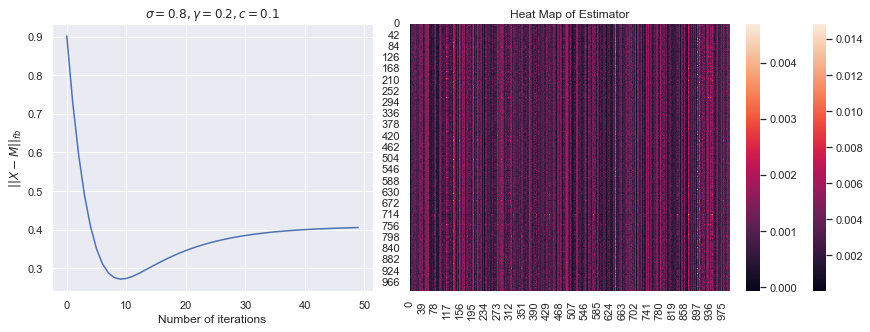

In [86]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.2
- Nuclear Norm Regularization Constant: 0.1
- Number of Iterations = 50

  0%|          | 0/50 [00:01<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

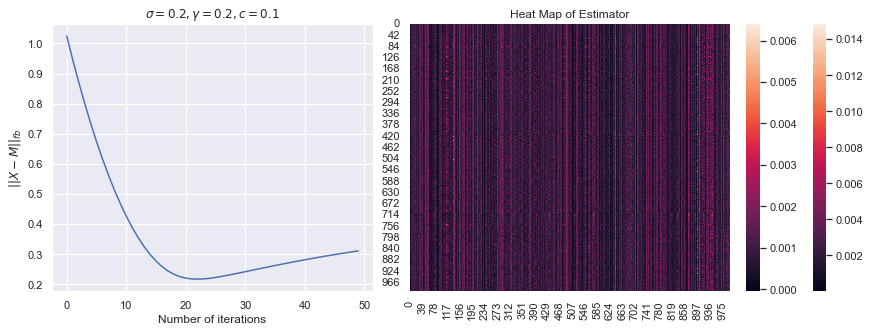

In [87]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.2)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.2
- Nuclear Norm Regularization Constant: 0.1
- Number of Iterations = 100

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

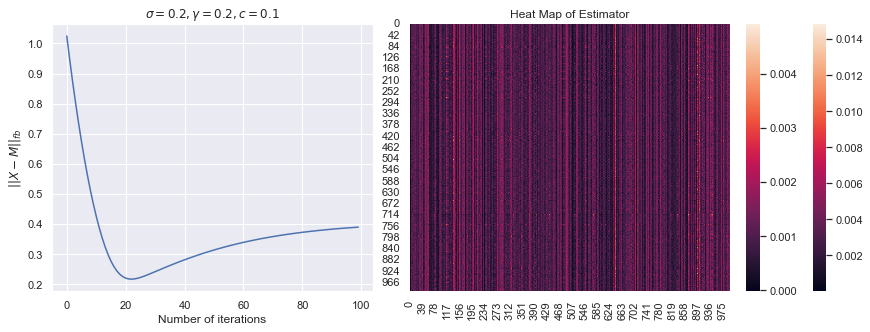

In [88]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.2)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=100)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.8
- Nuclear Norm Regularization Constant: 0.8
- Number of Iterations = 50

  0%|          | 0/50 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

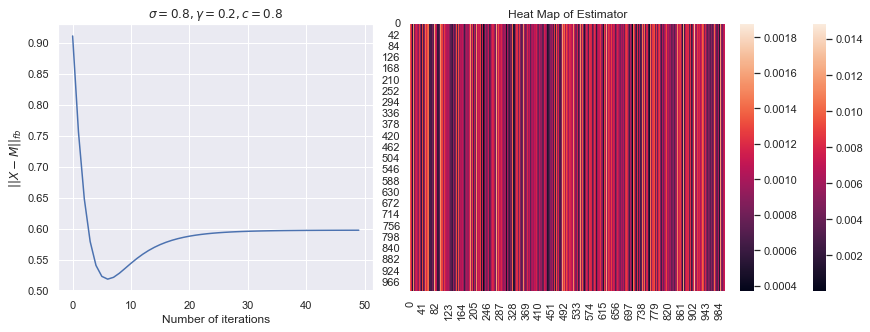

In [89]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.8, c=0.8)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=50)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.8
- Nuclear Norm Regularization Constant: 1.3
- Number of Iterations = 50

  0%|          | 0/50 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

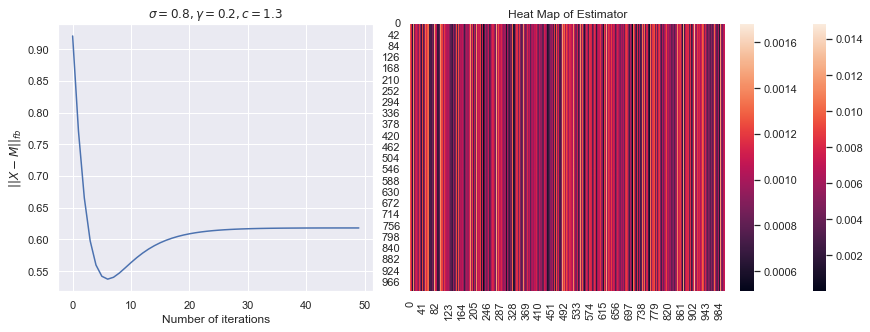

In [90]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.8, c=1.3)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=50)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.8
- Nuclear Norm Regularization Constant: 0.05
- Number of Iterations = 50

  0%|          | 0/50 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

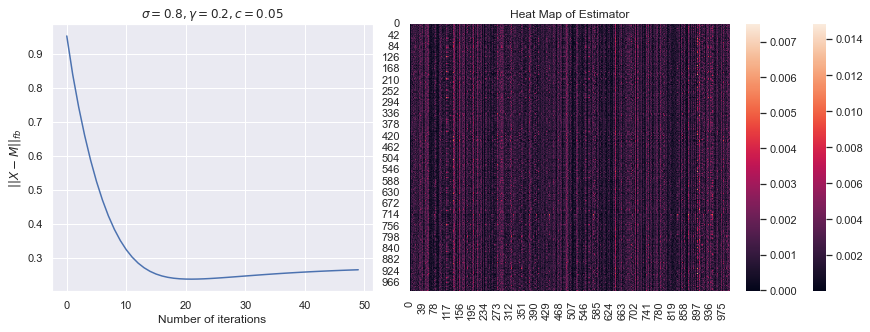

In [91]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.8, c=0.05)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=50)
visualizeMatrix(estimator)

In [92]:
print(np.linalg.norm(estimator, ord='nuc'))

3.139388434938997


*Parameters:*
- Step Length: 0.2
- Penalty = 0.8
- Nuclear Norm Regularization Constant: 0.07
- Number of Iterations = 50

  0%|          | 0/50 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

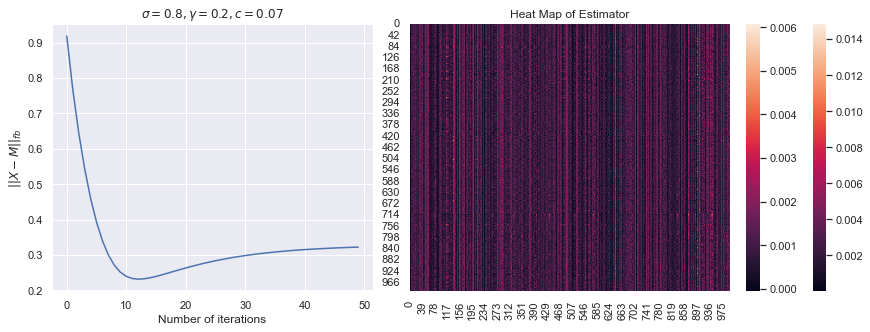

In [93]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.8, c=0.07)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=50)
visualizeMatrix(estimator)

In [94]:
print(np.linalg.norm(estimator, ord='nuc'))

1.9980086653440272


*Parameters:*
- Step Length: 0.2
- Penalty = 0.2
- Nuclear Norm Regularization Constant: 0.02
- Number of Iterations = 50

  0%|          | 0/50 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

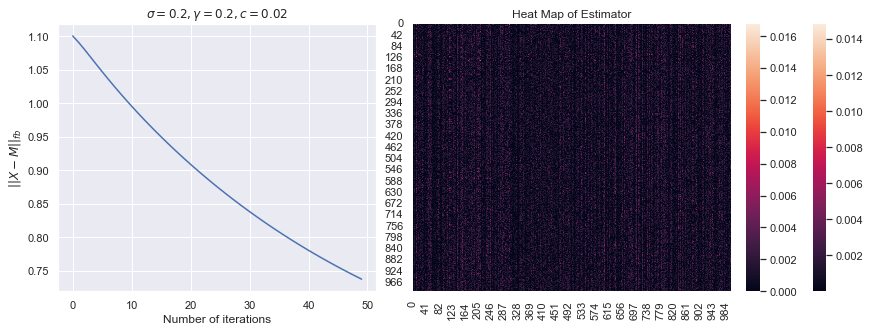

In [95]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.2, c=0.02)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=50)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.25
- Nuclear Norm Regularization Constant: 0.02
- Number of Iterations = 100

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

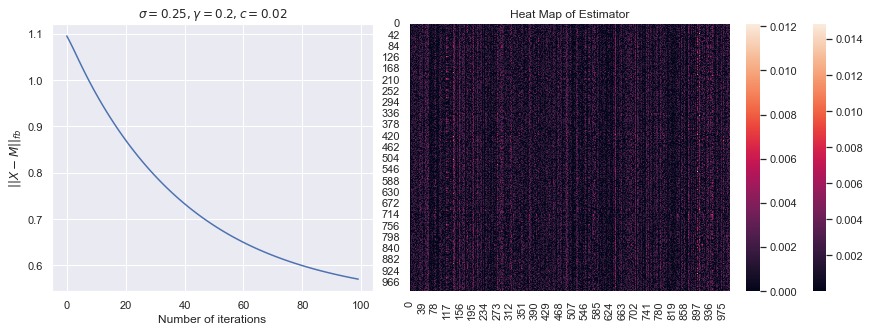

In [96]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.25, c=0.02)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=100)
visualizeMatrix(estimator)

*Parameters:*
- Step Length: 0.2
- Penalty = 0.1
- Nuclear Norm Regularization Constant: 0.05
- Number of Iterations = 100

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

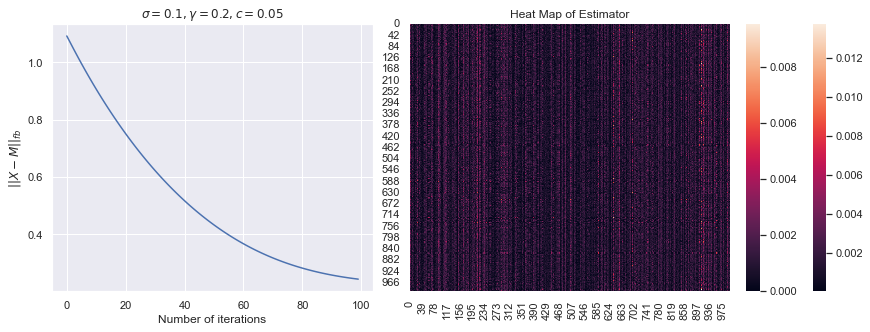

In [10]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.1, c=0.05)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=100)
visualizeMatrix(estimator)

In [11]:
print(np.linalg.norm(estimator, ord='nuc'))

4.679491411688427


*Parameters:*
- Step Length: 0.2
- Penalty = 0.17
- Nuclear Norm Regularization Constant: 0.05
- Number of Iterations = 100

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Heat Map of Estimator'}>

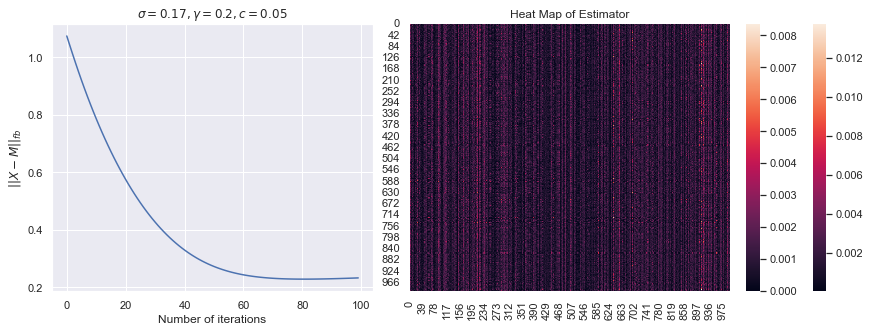

In [12]:
initial_point, penalty, c, compute_functions = initialPoint(p, N, mle, penalty=0.17, c=0.05)
estimator = runAlgorithm(initial_point, penalty, c, compute_functions, iter_number=100)
visualizeMatrix(estimator)

In [13]:
print(np.linalg.norm(estimator, ord='nuc'))

3.501358181998955
